## Load an LTSF-Linear Model

Train the model through 'electricity.sh' bash script.
Load an .pth file from the checkpoints folder.

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=96, out_features=24, bias=True)
  (Linear_Trend): Linear(in_features=96, out_features=24, bias=True)
) with 4656 parameters


tensor([[[4152.0674],
         [3495.8188],
         [3225.3906],
         [3022.0786],
         [2973.8225],
         [3090.0791],
         [2915.9844],
         [2689.2310],
         [3014.1890],
         [3630.1182],
         [4134.5713],
         [4940.9497],
         [5454.9185],
         [5119.6987],
         [4766.4385],
         [4388.5107],
         [4462.0210],
         [4687.0996],
         [5484.7061],
         [5941.2056],
         [5857.9160],
         [5516.3926],
         [5156.3457],
         [4672.3027]]], grad_fn=<PermuteBackward0>)


/mnt/zkpet/venv/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


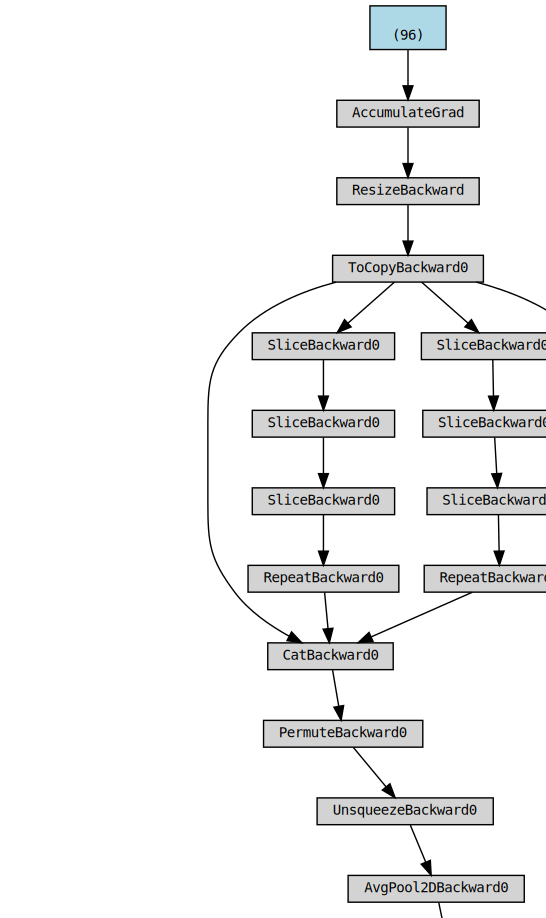

In [99]:
import torch
from torchviz import make_dot
import pandas as pd
import sys
sys.path.append("..")
from models.DLinear import Model as DLinear
from models.Linear import Model as Linear
from models.NLinear import Model as NLinear


class Configs:
    def __init__(self, seq_len, pred_len):
      self.seq_len = seq_len
      self.pred_len = pred_len
      self.enc_in = 321
      self.individual = False

model = 'DLinear'
target = '40'
seq_len = 96
pred_len = 24

configs = Configs(seq_len, pred_len)
match model:
  case 'Linear':
    circuit = Linear(configs)
  case 'DLinear':
    circuit = DLinear(configs)
  case 'NLinear':
    circuit = NLinear(configs)

basepath = '../checkpoints/Electricity_{}_{}_{}_custom_ftS_tg{}_sl{}_ll48_pl{}_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0/checkpoint.pth'
check_point_model = basepath.format(seq_len, pred_len, model, target, seq_len, pred_len)

if int(target) < 50 and model == 'Linear':
    basepath = '../checkpoints/checkpoint_{}_{}_tg{}.pth'
    check_point_model = basepath.format(seq_len, pred_len, target)

state_dict = torch.load(check_point_model)
circuit.load_state_dict(state_dict)

total_params = sum(
	param.numel() for param in circuit.parameters()
)

print(circuit, 'with {} parameters'.format(total_params))

df = pd.read_csv('../dataset/electricity.csv')
# Load the last seq_len entries data as input and converts to tensor
# x = 10*torch.rand(1,*[seq_len, 1], requires_grad=True)
x = torch.tensor(df[target][-seq_len:].values, requires_grad=True).resize(1, seq_len, 1).float()
# Flips the neural net into inference mode
circuit.eval()

y = circuit(x)
print(y)

# Visualize the trained model
make_dot(y.mean(), params=dict(circuit.named_parameters()))

## ZK Inference

#### Define Files Path

In [100]:
import tracemalloc
import os
import json
from timeit import default_timer as timer

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')
proof_path = os.path.join('test.pf')
sol_code_path = os.path.join('verify.sol')
abi_path = os.path.join('verify.abi')

#### Convert Model to ONNX

In [101]:
# Model was trained by 'electricity.sh' and stored into the checkpoint state 'checkpoint.pth'.
# Now we need to export the onnx file from this state file with model inputs.

# Export the model
torch.onnx.export(circuit,               # model being run
                      x,                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

# Serialize data into file:
json.dump( data, open(data_path, 'w' ))

input_size = os.stat(data_path).st_size / 1024
onnx_size = os.stat(model_path).st_size / 1024
print("Input.json size: {}KB".format(input_size))
print("network.onnx size: {}KB".format(onnx_size))

Input.json size: 0.767578125KB
network.onnx size: 22.76171875KB


### Setup

In [102]:
import ezkl

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.output_visibility = "kzgcommit"
run_args.param_visibility = "private"
run_args.variables = [("batch_size", 1)]
run_args.logrows = 20

try:
    table_string = ezkl.table(model_path, run_args)
    print(table_string)
except Exception as e:
    print(f"An error occurred: {e}")

Unknown op: MultiBroadcastTo
Unknown op: MultiBroadcastTo
thread '<unnamed>' panicked at src/graph/utilities.rs:1154:68:
index out of bounds: the len is 1 but the index is 1


PanicException: index out of bounds: the len is 1 but the index is 1

In [4]:
import ezkl
import os

model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.ezkl')
settings_path = os.path.join('settings.json')

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "private"
run_args.output_visibility = "kzgcommit"
run_args.param_visibility = "private"
run_args.variables = [("batch_size", 1)]
run_args.logrows = 20

res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

Unknown op: MultiBroadcastTo
Unknown op: MultiBroadcastTo
thread '<unnamed>' panicked at src/graph/utilities.rs:1154:68:
index out of bounds: the len is 1 but the index is 1
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: index out of bounds: the len is 1 but the index is 1

In [107]:
# Setup is performed by the application developer, who then deploys the resulting artifacts to production.

!RUST_LOG=trace
# TODO: Dictionary outputs
# Before setup can run, the settings need to be generated with gen-settings
#  and optionally calibrate-settings, and the model must be compiled.

tracemalloc.start()
start = timer()

res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
assert res == True

res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
assert res == True

res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
assert res == True

# Generate KZG srs
res = ezkl.get_srs(srs_path, settings_path)

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK

res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)

end = timer()
print("time used: {} seconds.".format(end - start))

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
print("[ Top 10 ]")
for stat in top_stats[:10]:
    print(stat)

Unknown op: MultiBroadcastTo
Unknown op: MultiBroadcastTo
thread '<unnamed>' panicked at src/graph/utilities.rs:1154:68:
index out of bounds: the len is 1 but the index is 1


PanicException: index out of bounds: the len is 1 but the index is 1

### Prove

In [ ]:
# Prove, invoked with ezkl prove at the cli or ezkl.prove() in Python, is called by the prover, often on the client.

# the witness data for the claim: an (input, output) pair (x,y) such that model(input) = output.
# this pair can be produced from x using the gen-witness command.
# now generate the witness file 

tracemalloc.start()
start = timer()
res = ezkl.gen_witness(
        data_path, 
        compiled_model_path, 
        witness_path
      )
# assert os.path.isfile(witness_path)

# GENERATE A PROOF

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "single"
    )

# print(res)
# assert os.path.isfile(proof_path)

end = timer()
prove_time = end - start
print("time used: {} seconds".format(prove_time))

snapshot = tracemalloc.take_snapshot()
top_stats = snapshot.statistics('lineno')
print("[ Top 10 ]")
for stat in top_stats[:10]:
    print(stat)

proof_size = os.stat(proof_path).st_size / 1024
print("{} size: {}KB".format(proof_path, proof_size))

spawning module 2


spawning module 3


time used: 0.9015573598444462 seconds
[ Top 10 ]
/mnt/zkpet/venv/lib/python3.10/site-packages/pandas/core/internals/managers.py:2200: size=64.6 MiB, count=9, average=7352 KiB
/usr/lib/python3.10/ast.py:50: size=11.0 MiB, count=205717, average=56 B
/mnt/zkpet/venv/lib/python3.10/site-packages/IPython/core/completer.py:3343: size=10.9 MiB, count=137715, average=83 B
/mnt/zkpet/venv/lib/python3.10/site-packages/executing/executing.py:265: size=2100 KiB, count=32338, average=66 B
/mnt/zkpet/venv/lib/python3.10/site-packages/pandas/io/parsers/c_parser_wrapper.py:234: size=1751 KiB, count=26391, average=68 B
/mnt/zkpet/venv/lib/python3.10/site-packages/asttokens/line_numbers.py:47: size=1685 KiB, count=8565, average=201 B
/mnt/zkpet/venv/lib/python3.10/site-packages/executing/executing.py:236: size=1631 KiB, count=16635, average=100 B
/usr/lib/python3.10/linecache.py:137: size=1303 KiB, count=13289, average=100 B
/mnt/zkpet/venv/lib/python3.10/site-packages/executing/executing.py:227: size=1

### Verify

#### VERIFY off-chain

In [ ]:
start = timer()
res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")
end = timer()
print("time used: {} seconds".format(end - start))

verified
time used: 0.01522378996014595 seconds


#### VERIFY on-chain

In [ ]:
# Create verifier contract
res = ezkl.create_evm_verifier(
        vk_path,
        srs_path,
        settings_path,
        sol_code_path,
        abi_path,
    )
verifier_size = os.stat(sol_code_path).st_size / 1024
print("{} size: {}KB".format(sol_code_path, verifier_size))

verify.sol size: 58.140625KB


In [ ]:
# Deploy the verifier contract onchain
sol_code_path = os.path.join("verify.sol")
address_path = os.path.join('contractAddr.txt')
# assuming anvil is running
res = ezkl.deploy_evm(
    address_path,
    sol_code_path,
    'http://127.0.0.1:3030'
)

assert res == True

In [ ]:
# Verify proof onchain

with open(address_path, 'r') as f:
  addr = f.readline()

res = ezkl.verify_evm(
    proof_path,
    addr,
    'http://127.0.0.1:3030'
)

assert res == True

## Stats

In [ ]:
import numpy as np
from subprocess import Popen, PIPE

input_size = np.round(os.stat(data_path).st_size / 1024, 3)
onnx_size = np.round(os.stat(model_path).st_size / 1024, 3)
print("{} size: {}KB".format(data_path, input_size))
print("{} size: {}KB".format(model_path, onnx_size))
proof_size = np.round(os.stat(proof_path).st_size / 1024, 3)
print("{} size: {}KB".format(proof_path, proof_size))
print("prove time used: {} seconds".format(np.round(prove_time, 3)))
verifier_size = np.round(os.stat(sol_code_path).st_size / 1024, 3)
print("{} size: {}KB".format(sol_code_path, verifier_size))

p = Popen(["solc", "--bin", "--optimize", "verify.sol"], stdin=PIPE, stdout=PIPE, stderr=PIPE)
output, err = p.communicate(b"input data that is passed to subprocess' stdin")
verifier_code_size = np.round(sys.getsizeof((output.split(b'\n')[3])) / 1000, 3)
print("Verifier bytecode size: {}KB".format(verifier_code_size))

input.json size: 0.768KB
network.onnx size: 10.107KB
test.pf size: 22.823KB
prove time used: 0.902 seconds
verify.sol size: 58.141KB
Verifier bytecode size: 13.995KB


In [ ]:
import pandas as pd
import numpy as np

with open("../result.txt", "r") as file:
  lines = file.readlines()
mse, mae, rse, tg = [], [], [], []
for line in lines:
  if 'tg' in line:
    # print(line)
    tg.append(line.split('tg')[1].split('_')[0])
  if 'mse' in line:
    mse.append(round(float(line.split('mse:')[1].split(',')[0]), 3))
  if 'mae' in line:
    mae.append(round(float(line.split('mae:')[1].split(',')[0]), 3))
  if 'rse' in line:
    rse.append(round(float(line.split('rse:')[1].split(',')[0]), 3))


idx = ['96', '192', '336', '720']
cols = list(dict.fromkeys(tg))


x_mse = np.reshape(mse, (int(len(mse)/len(idx)), len(idx))).T
df_mse = pd.DataFrame(x_mse, columns=cols, index=idx)
df_mse

ValueError: Shape of passed values is (4, 11), indices imply (4, 10)

In [ ]:
x_mae = np.reshape(mae, (int(len(mae)/len(idx)), len(idx))).T
df_mae = pd.DataFrame(x_mae, columns=cols, index=idx)
df_mae

,OT,0,10,20,30,40,50,60,70,80
96,0.397,0.248,0.268,0.393,0.309,0.249,0.591,0.289,0.360,0.354
192,0.277,0.266,0.244,0.351,0.283,0.205,0.470,0.252,0.329,0.273
336,0.264,0.260,0.239,0.348,0.287,0.200,0.451,0.242,0.321,0.264
720,0.252,0.288,0.236,0.355,0.290,0.195,0.437,0.235,0.323,0.254
